## Imports

In [17]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import copy

import itertools
import json
import logging
import math
from abc import ABC, abstractmethod
from collections import Counter
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import transformers.utils.logging as transformers_utils_logging
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import (
    DistributedDataParallelKwargs,
    ProjectConfiguration,
    set_seed,
)
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_scheduler,
    HfArgumentParser,
    PreTrainedTokenizer,
)

plt.rcParams["font.family"] = "DejaVu Sans"

IGNORE_INDEX = -100

TRANSFORMERS_PATH_MAP = {
    "llama-3.2-1b-instruct": "meta-llama/Llama-3.2-1B-Instruct",
    "llama-3.1-8b-instruct": "meta-llama/Llama-3.1-8B-Instruct",
}

## Dataset

In [19]:
######################################## Datset ########################################


def row2text_template_scifact(row):
    text = f"Title: {row['title']}\nAbstract: {' '.join(row['abstract'])}\nStructured: {row['structured']}\n"
    # Remove all newlines and strip extra spaces
    text = text.replace("\n", " ")
    return text


class SciFactCorpusDataset(Dataset):
    def __init__(self, corpus_path):
        super().__init__()
        corpus = pd.read_json(corpus_path, lines=True)
        corpus["text"] = corpus.apply(row2text_template_scifact, axis=1)

        self.corpus = corpus
        self.corpus_dict = corpus.set_index("doc_id")["text"].to_dict()

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, i):
        doc_id = self.corpus["doc_id"][i]
        text = self.corpus_dict.get(doc_id)
        return {
            "doc_id": doc_id,
            "text": text,
        }

    def get_corpus_dict(self):
        return self.corpus_dict


def get_scifact_corpus_dataloader(
    corpus_path,
    batch_size=4,
    shuffle=False,
    num_workers=0,
):
    scifact_corpus_dataset = SciFactCorpusDataset(corpus_path)
    dataloader = DataLoader(
        scifact_corpus_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
    )
    return dataloader


class SciFactQueryDataset(Dataset):
    def __init__(self, queries_path, corpus_dict):
        super().__init__()
        if isinstance(queries_path, str):
            self.queries = pd.read_json(queries_path, lines=True)
        elif isinstance(queries_path, list):
            queries = []
            for path in queries_path:
                queries.append(pd.read_json(path, lines=True))
            self.queries = pd.concat(queries, ignore_index=True)
        else:
            raise ValueError("queries_path must be a string or a list of strings")

        self.corpus_dict = corpus_dict

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, i):
        doc_id_list = self.queries["cited_doc_ids"][i]
        query = self.queries["claim"][i]

        docs = []
        for doc_id in doc_id_list:
            docs.append(self.corpus_dict.get(doc_id))

        n_docs = len(docs)

        if n_docs == 0:
            return {}
        else:
            queries = [query] * n_docs

        return {
            "doc_id": doc_id_list,
            "query": queries,
            "text": docs,
        }


def scifact_query_collate_fn(batch):
    batch = [item for item in batch if item]
    if not batch:
        return {}
    doc_ids = sum([item["doc_id"] for item in batch], [])
    queries = sum([item["query"] for item in batch], [])
    texts = sum([item["text"] for item in batch], [])
    return {
        "doc_id": doc_ids,
        "query": queries,
        "text": texts,
    }


def get_scifact_query_dataloader(
    queries_path: str | list[str],
    corpus_dict,
    batch_size=4,
    shuffle=False,
    num_workers=0,
):
    scifact_query_dataset = SciFactQueryDataset(
        queries_path,
        corpus_dict,
    )
    dataloader = DataLoader(
        scifact_query_dataset,
        batch_size=batch_size,
        collate_fn=scifact_query_collate_fn,  # NOTE: This is for query dataset only
        shuffle=shuffle,
        num_workers=num_workers,
    )
    return dataloader

## Model

In [18]:
######################################## Model ########################################


def get_special_tokens_dict(tokenizer):
    special_tokens_dict = {}
    if tokenizer.pad_token is None:
        special_tokens_dict["pad_token"] = "[PAD]"
    if tokenizer.eos_token is None:
        special_tokens_dict["eos_token"] = "</s>"
    if tokenizer.bos_token is None:
        special_tokens_dict["bos_token"] = "<s>"
    if tokenizer.unk_token is None:
        special_tokens_dict["unk_token"] = "<unk>"
    return special_tokens_dict


def smart_tokenizer_and_embedding_resize(
    special_tokens_dict,
    tokenizer,
    model,
):
    num_new_tokens = tokenizer.add_special_tokens(special_tokens_dict)
    model.resize_token_embeddings(len(tokenizer))

    if num_new_tokens > 0:
        input_embeddings = model.get_input_embeddings().weight.data
        output_embeddings = model.get_output_embeddings().weight.data

        input_embeddings_avg = input_embeddings[:-num_new_tokens].mean(
            dim=0, keepdim=True
        )
        output_embeddings_avg = output_embeddings[:-num_new_tokens].mean(
            dim=0, keepdim=True
        )

        input_embeddings[-num_new_tokens:] = input_embeddings_avg
        output_embeddings[-num_new_tokens:] = output_embeddings_avg


def _tokenize_fn(strings: list[str], tokenizer: PreTrainedTokenizer):
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )
        for text in strings
    ]
    input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item()
        for tokenized in tokenized_list
    ]
    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )


def get_model_and_tokenizer(
    model_name_or_path,
    model_max_length=1024,
    torch_dtype=torch.bfloat16,
    padding_side="right",
):
    tokenizer = AutoTokenizer.from_pretrained(
        model_name_or_path,
        model_max_length=model_max_length,
        padding_side=padding_side,
        use_fast=False,
    )
    special_tokens_dict = get_special_tokens_dict(tokenizer)
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        low_cpu_mem_usage=True,
        torch_dtype=torch_dtype,
    )
    smart_tokenizer_and_embedding_resize(
        special_tokens_dict=special_tokens_dict,
        tokenizer=tokenizer,
        model=model,
    )
    return model, tokenizer


class GenXTransformer:
    def __init__(
        self,
        query_model,
        doc_model,
        train_tokenizer,
        inference_tokenizer,
        num_beams: int = 5,
        num_next_tokens: int = 5,
    ):
        super().__init__()
        self.query_model = query_model
        self.doc_model = doc_model

        self.train_tokenizer = train_tokenizer
        self.inference_tokenizer = inference_tokenizer

        self.num_beams = num_beams
        self.num_next_tokens = num_next_tokens

        self.verbose = False

        self.config_genx_gen_kwargs(
            num_beams=num_beams,
            num_return_sequences=num_beams,
            max_new_tokens=num_next_tokens,
        )

    def set_train_eval_mode(self, query_train: bool = True, doc_train: bool = False):
        if query_train:
            self.query_model.train()
        else:
            self.query_model.eval()
        if doc_train:
            self.doc_model.train()
        else:
            self.doc_model.eval()

    def update_num_next_tokens(self, num_next_tokens: int):
        self.num_next_tokens = num_next_tokens
        self.genx_gen_kwargs["max_new_tokens"] = num_next_tokens

    def config_genx_gen_kwargs(self, **kwargs):
        gen_kwargs = {
            "max_new_tokens": kwargs.get("max_new_tokens", 5),
            "do_sample": False,
            "num_beams": kwargs.get("num_beams", 1),
            "num_return_sequences": kwargs.get("num_return_sequences", 1),
            "eos_token_id": kwargs.get("eos_token_id", None),
        }
        self.genx_gen_kwargs = gen_kwargs

    def index_prompt(self, prompts, model, tokenizer, shift=0):

        device = model.device

        if isinstance(prompts, str):
            prompts = [prompts]

        batch = tokenizer(
            prompts,
            return_tensors="pt",
            padding="longest",
        )

        genx_gen_kwargs = self.genx_gen_kwargs.copy()
        genx_gen_kwargs["max_new_tokens"] += shift

        bad_chars = ["#", "\n", ".", "}", "{", "step"] + list("0123456789")
        bad_words_ids = [
            tokenizer.encode(char, add_special_tokens=False) for char in bad_chars
        ]

        with torch.no_grad():
            genx_gen_kwargs["input_ids"] = batch["input_ids"].to(device)
            genx_gen_kwargs["attention_mask"] = batch["attention_mask"].to(device)
            generated_tokens = model.generate(
                **genx_gen_kwargs,
                bad_words_ids=bad_words_ids,
            )

        input_len = len(batch["input_ids"][0])
        pred_next_tokens = generated_tokens[:, input_len + shift :]
        if self.verbose:
            print(
                "Decoded tokens:",
                tokenizer.batch_decode(pred_next_tokens, skip_special_tokens=False),
            )

        batch_size = len(prompts)
        num_return_sequences = genx_gen_kwargs["num_return_sequences"]

        pred_next_tokens = pred_next_tokens.view(batch_size, num_return_sequences, -1)
        pred_next_tokens = pred_next_tokens.cpu().tolist()

        print("Token IDs:", pred_next_tokens) if self.verbose else None
        return pred_next_tokens

    def index_query(self, prompts: list[str]):
        return self.index_prompt(prompts, self.query_model, self.inference_tokenizer, 0)

    def index_doc(self, prompts: list[str]):
        return self.index_prompt(prompts, self.doc_model, self.inference_tokenizer, 3)

    def get_sft_loss_txt(self, model, tokenizer, prompts: list[str]):
        tokens = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=tokenizer.model_max_length,
        ).to(model.device)

        input_ids = tokens["input_ids"]
        attention_mask = tokens["attention_mask"]

        labels = input_ids.clone()
        keep = self.num_next_tokens
        for i, mask in enumerate(attention_mask):
            length = mask.sum().item()
            cutoff = max(0, length - keep)
            labels[i, :cutoff] = IGNORE_INDEX
            labels[i, length:] = IGNORE_INDEX

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
        )
        return outputs.loss

    def __call__(self, queries: list[str], docs: list[str]):
        # Now this is fine-tuning query model to generate next tokens of document
        assert len(queries) == len(docs)

        if isinstance(docs[0], str):
            beams_for_docs: list[list[list[int]]] = self.index_doc(
                docs,
            )  # Shape is num_docs x num_beams x num_next_tokens
        else:
            beams_for_docs = docs

        # Shape is num_docs x num_beams x (len(query) + num_next_tokens)
        prompts_for_all_pairs: list[list[str]] = []
        for doc_idx, beams in enumerate(beams_for_docs):
            beams = self.inference_tokenizer.batch_decode(beams, skip_special_tokens=False)
            prompts = []  # List of the same query and num_beams possible next sentences

            query = queries[doc_idx]
            num_beams = len(beams)
            for beams_idx in range(num_beams):
                prompt = query + beams[beams_idx]
                prompts.append(prompt)
            prompts_for_all_pairs.append(prompts)

        # Have num_docs x num_beams sequences, each of a string of length (len(query) + num_next_tokens)
        flats: list[str] = list(itertools.chain.from_iterable(prompts_for_all_pairs))
        loss = self.get_sft_loss_txt(self.query_model, self.train_tokenizer, flats)
        return loss

## Store

In [20]:
######################################## Store ########################################


class Document:
    def __init__(self, text, metadata):
        self._text = text
        self._metadata = metadata

    def get_text(self):
        return self._text

    def get_metadata(self):
        return self._metadata


class IndexStoreTemplate(ABC):
    def __init__(self, initial_capacity=1000):
        # Capacity and initial capacity
        self._initial_capacity = initial_capacity
        self.capacity = initial_capacity

        # Data and global index of elements
        self.next_id = 0
        self.size = 0
        self._ids = np.zeros(self.capacity, dtype=np.int64)
        self._data_store = {}  # id to text
        self._beams_store = {}  # id to beams
        self._original_keys = {}  # id to original key in the dataset
        self._original_keys_transpose = {}

    def _resize_if_needed(self, additional_items=16):
        if self.size + additional_items > self.capacity:
            new_capacity = max(self.capacity * 2, self.size + additional_items)

            # Resize ID array
            new_ids = np.zeros(new_capacity, dtype=np.int64)
            new_ids[: self.size] = self._ids[: self.size]
            self._ids = new_ids

            self.capacity = new_capacity

    def _clear_store(self):
        self.capacity = self._initial_capacity
        self.next_id = 0
        self.size = 0
        self._ids = np.zeros(self._initial_capacity, dtype=np.int64)
        self._data_store = {}
        self._beams_store = {}
        self._original_keys = {}
        self._original_keys_transpose = {}

    def retrieve(self, doc_id):
        return self._data_store[doc_id]

    @abstractmethod
    def insert(self, text: list[Document]):
        pass

    @abstractmethod
    def query(self, query_text: Document) -> list[list[int]]:
        pass

    @staticmethod
    def plot_list_frequencies(
        data,
        figsize=(12, 8),
        show_top_n=10,
        save_path=None,
        verbose=False,
    ):
        # Extract all lists and convert to tuples for counting
        all_lists = []
        for list_of_lists in data.values():
            for sublist in list_of_lists:
                all_lists.append(tuple(sublist))

        if not all_lists:
            print("No data found in the input dictionary.")
            return {}

        # Count frequencies of each unique list
        list_freq = Counter(all_lists)

        # Count the frequency of frequencies
        freq_of_freq = Counter(list_freq.values())

        # Create the figure and axes
        fig, axes = plt.subplots(2, 1, figsize=figsize)

        # Plot 1: Frequency of frequencies
        frequencies = sorted(freq_of_freq.keys())
        counts = [freq_of_freq[f] for f in frequencies]

        axes[0].bar(
            frequencies, counts, color="lightblue", edgecolor="black", alpha=0.7
        )
        axes[0].set_xlabel("ID Count", fontsize=12)
        axes[0].set_ylabel("Number of lists", fontsize=12)
        axes[0].set_title("Distribution of List Frequencies", fontsize=14)
        axes[0].grid(axis="y", linestyle="--", alpha=0.6)
        axes[0].set_xticks(frequencies)

        # Plot 2: Histogram of all frequency values
        all_frequency_values = list(list_freq.values())
        max_freq = max(all_frequency_values)
        axes[1].hist(
            all_frequency_values,
            bins=range(1, max_freq + 2),
            rwidth=0.8,
            align="left",
            color="lightcoral",
            edgecolor="black",
            alpha=0.7,
        )
        axes[1].set_xlabel("Frequency", fontsize=12)
        axes[1].set_ylabel("Count", fontsize=12)
        axes[1].set_title("Histogram of List Frequencies", fontsize=14)
        axes[1].grid(axis="y", linestyle="--", alpha=0.6)
        axes[1].set_xticks(range(1, max_freq + 1))

        plt.tight_layout()

        # Save or show the plot
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Plot saved to {save_path}")
        else:
            plt.show()

        if verbose:
            # Calculate statistics
            stats = {
                "total_lists": len(all_lists),
                "unique_lists": len(list_freq),
                "lists_appearing_once": freq_of_freq.get(1, 0),
                "lists_appearing_multiple": sum(
                    count for freq, count in freq_of_freq.items() if freq > 1
                ),
                "max_frequency": max(all_frequency_values),
                "frequency_distribution": dict(freq_of_freq),
            }

            # Print statistics
            print("Summary Statistics:")
            print(f"Total number of lists: {stats['total_lists']}")
            print(f"Number of unique lists: {stats['unique_lists']}")
            print(f"Lists appearing once: {stats['lists_appearing_once']}")
            print(
                f"Lists appearing more than once: {stats['lists_appearing_multiple']}"
            )
            print(f"Maximum frequency: {stats['max_frequency']}")

            # Show top frequent lists
            if len(list_freq) <= show_top_n * 2:
                print("\nAll unique lists and their frequencies:")
                for i, (unique_list, count) in enumerate(
                    sorted(list_freq.items(), key=lambda x: x[1], reverse=True), 1
                ):
                    print(f"{i:2d}: {list(unique_list)} appears {count} time(s)")
            else:
                print(f"\nTop {show_top_n} most frequent lists:")
                for i, (unique_list, count) in enumerate(
                    sorted(list_freq.items(), key=lambda x: x[1], reverse=True)[
                        :show_top_n
                    ],
                    1,
                ):
                    print(f"{i:2d}: {list(unique_list)} appears {count} time(s)")

            print("\nFrequency distribution:")
            for freq in sorted(freq_of_freq.keys()):
                print(f"{freq_of_freq[freq]} lists appear exactly {freq} time(s)")

            return stats


class PrefixTreeNode:
    def __init__(self):
        self.children = {}
        self.doc_ids = set()


class Prompt:
    def __init__(self, before, after):
        self.before = before
        self.after = after

    def format(self, text):
        return self.before + text + self.after


class SequencePrefixTreeIndexStore(IndexStoreTemplate):
    def __init__(
        self,
        transformer,
        id_len,
        universe,
        doc_prompt: Prompt,
        query_prompt: Prompt,
        verbose=False,
        initial_capacity=1000,
        insertion_depth=3,
        mode="document_search",
    ):
        super().__init__(initial_capacity)

        assert mode in ["duplicate_detection", "document_search"]
        self.mode = mode

        self.doc_prompt = doc_prompt
        self.query_prompt = query_prompt

        # Model for generating indices for inserted documens
        self.transformer: GenXTransformer = transformer
        self.id_len = id_len
        self.universe = set(universe)

        # Verbose
        self.verbose = verbose

        # Prefix tree
        self.root = PrefixTreeNode()
        self.insertion_depth = insertion_depth

    def save_state(self, filepath):
        import joblib

        # Create a state dictionary with all attributes except transformer
        state = {
            # Capacity and sizing
            "_initial_capacity": self._initial_capacity,
            "capacity": self.capacity,
            "next_id": self.next_id,
            "size": self.size,
            # Data storage
            "_ids": self._ids,
            "_data_store": self._data_store,
            "_beams_store": self._beams_store,
            "_original_keys": self._original_keys,
            "_original_keys_transpose": self._original_keys_transpose,
            # Configuration
            "mode": self.mode,
            "doc_prompt": self.doc_prompt,
            "query_prompt": self.query_prompt,
            "id_len": self.id_len,
            "universe": self.universe,
            "verbose": self.verbose,
            "insertion_depth": self.insertion_depth,
            # Prefix tree
            "root": self.root,
        }

        # Save using joblib
        joblib.dump(state, filepath)
        print(f"State saved to {filepath}")

    def load_state(self, filepath):
        import joblib

        # Load the state
        state = joblib.load(filepath)

        # Restore all attributes
        self._initial_capacity = state["_initial_capacity"]
        self.capacity = state["capacity"]
        self.next_id = state["next_id"]
        self.size = state["size"]
        self._ids = state["_ids"]
        self._data_store = state["_data_store"]
        self._beams_store = state["_beams_store"]
        self._original_keys = state["_original_keys"]
        self._original_keys_transpose = state["_original_keys_transpose"]
        self.mode = state["mode"]
        self.doc_prompt = state["doc_prompt"]
        self.query_prompt = state["query_prompt"]
        self.id_len = state["id_len"]
        self.universe = state["universe"]
        self.verbose = state["verbose"]
        self.insertion_depth = state["insertion_depth"]
        self.root = state["root"]

        print(f"State loaded from {filepath}")

    def print_data(self):
        for id, val in self._data_store.items():
            print(val.get_text(), val.get_metadata())
            print(self._beams_store[id])
            print()

    def print_beams_store(self):
        for id, val in self._beams_store.items():
            print(
                id,
                val,
                self.transformer.inference_tokenizer.batch_decode(
                    val, skip_special_tokens=False
                ),
            )

    def set_verbose_for_all(self, verbose):
        self.verbose = verbose
        if hasattr(self.transformer, "verbose"):
            self.transformer.verbose = verbose

    def reset_id_len(self, id_len):
        self.id_len = id_len
        self.transformer.update_num_next_tokens(max_new_tokens=id_len)

    def clear_store(self):
        self.root = PrefixTreeNode()

        super()._clear_store()
        if self.verbose:
            print(f"Store cleared, current capacity: {self.capacity}")

    def _insert_document(self, texts: list[Document], prompt_template):
        if not isinstance(texts, list):
            texts = [texts]

        self._resize_if_needed(len(texts))

        doc_ids = []
        template_texts = []
        for text in texts:
            doc_id = self.next_id
            doc_ids.append(doc_id)
            # Update index in data store
            self.next_id += 1
            self.size += 1

            # Save text in data store
            self._ids[self.size - 1] = doc_id
            self._data_store[doc_id] = text
            self._original_keys[doc_id] = text.get_metadata()["doc_id"]
            self._original_keys_transpose[text.get_metadata()["doc_id"]] = doc_id

            template_text = prompt_template(text.get_text())
            template_texts.append(template_text)

        # Generate beams of sequences
        # [batch_size, num_return_sequences, sequence_length]
        lst_of_sequences = self.transformer.index_doc(template_texts)
        print(lst_of_sequences) if self.verbose else None
        self._insert_sequences_into_tree(lst_of_sequences, doc_ids)

    def _insert_sequences_into_tree(
        self, lst_of_sequences: list[list[list[int]]], doc_ids: list[int]
    ):
        for sequences, doc_id in zip(lst_of_sequences, doc_ids):
            # Store sequences of a doc in to database
            self._beams_store[doc_id] = sequences

            for seq in sequences:
                print(f"Tokens: {seq}") if self.verbose else None
                if len(seq) != self.id_len or not all(x in self.universe for x in seq):
                    continue  # Skip invalid sequences

                self._traverse_and_insert(seq, doc_id)

    def _traverse_and_insert(self, seq, doc_id):
        node = self.root
        depth = 0

        for idx in seq:
            if idx not in node.children:
                node.children[idx] = PrefixTreeNode()
            node = node.children[idx]
            depth += 1
            if depth >= self.insertion_depth:
                node.doc_ids.add(doc_id)
                if self.verbose:
                    print(f"Inserted doc {doc_id} at depth {depth} of prefix tree")

    def insert(self, texts: list[Document]):
        _texts = []
        for text in texts:
            doc_id = text.get_metadata()["doc_id"]
            if doc_id not in self._original_keys.values():
                _texts.append(text)
        if len(_texts) > 0:
            print(f"Inserting '{_texts}'") if self.verbose else None
            self._insert_document(_texts, self.doc_prompt.format)

    def _query_with_prompt(
        self,
        query_texts: list[Document],
        prompt_template,
    ) -> list[list[dict]]:
        if not query_texts:
            return []

        lst_of_result_ids = []
        template_texts = []
        for query_text in query_texts:
            template_text = prompt_template(query_text.get_text())
            print(template_text) if self.verbose else None
            template_texts.append(template_text)

        # [batch_size, num_return_sequences, sequence_length]
        lst_of_sequences = self.transformer.index_query(template_texts)
        for sequences in lst_of_sequences:
            result_ids = []
            for seq in sequences:
                print(f"Tokens: {seq}") if self.verbose else None
                if len(seq) != self.id_len or not all(x in self.universe for x in seq):
                    continue

                result = self._traverse_tree_for_query(seq)
                if result:
                    result["index_ids"] = seq
                    result["index_txt"] = self.transformer.inference_tokenizer.batch_decode(
                        seq, skip_special_tokens=False
                    )
                    result_ids.append(result)
            print("Found results: ", result_ids) if self.verbose else None
            lst_of_result_ids.append(result_ids)

        return lst_of_result_ids

    def _traverse_tree_for_query(self, seq):
        node: PrefixTreeNode = self.root
        found = True
        depth = 0

        for idx in seq:
            if (idx not in node.children) and (depth < self.insertion_depth):
                found = False
                break
            if (idx not in node.children) and (depth >= self.insertion_depth):
                break
            node = node.children[idx]
            depth += 1

        if found:
            return {"depth": depth, "doc_ids": node.doc_ids}
        return None

    def query(self, query_texts: list[Document]):
        print(f"Querying for '{query_texts}'") if self.verbose else None
        return self._query_with_prompt(query_texts, self.query_prompt.format)

## Train

In [21]:
######################################## Train ########################################


def log_validation(
    store,
    scifact_dataloader,
    accelerator,
    epoch,
    split: str,
    global_step: int,
    is_final_validation: bool = False,
):
    cited_doc_ids = []
    results = []

    for batch in scifact_dataloader:
        # Use dict to automatically handle duplicates (keeps last occurrence)
        unique_queries = {}
        for query, doc_id in zip(batch["query"], batch["doc_id"]):
            if query not in unique_queries:
                unique_queries[query] = []
            unique_queries[query].append(doc_id)

        queries_to_be_queried = []
        doc_ids_for_a_query = []
        for query, doc_ids in unique_queries.items():
            queries_to_be_queried.append(Document(query, {"doc_ids": doc_ids}))
            doc_ids_for_a_query.append(doc_ids)

        result = store.query(queries_to_be_queried)
        results.extend(result)
        cited_doc_ids.extend(doc_ids_for_a_query)

    assert len(results) == len(cited_doc_ids)

    total_predicted = 0
    total_correctly_predicted = 0
    total_gold = 0

    for idx in range(len(results)):
        result = results[idx]
        cited_doc_id = cited_doc_ids[idx]

        # Extract predicted document IDs
        if len(result) > 0:
            temp = []
            for item in result:
                temp.extend(item["doc_ids"])
            predicted = set(temp)
        else:
            predicted = set()

        predicted = list(predicted)
        for idx, pred in enumerate(predicted):
            predicted[idx] = int(store._data_store[pred].get_metadata()["doc_id"])

        cited_doc_id = set(cited_doc_id)
        predicted = set(predicted)

        # Count metrics
        total_predicted += len(predicted)
        total_gold += len(cited_doc_id)

        # Count correctly predicted abstracts (intersection)
        correctly_predicted = predicted.intersection(set(cited_doc_id))
        total_correctly_predicted += len(correctly_predicted)

    # Calculate precision and recall
    if total_predicted > 0:
        precision = total_correctly_predicted / total_predicted
    else:
        precision = 0.0

    if total_gold > 0:
        recall = total_correctly_predicted / total_gold
    else:
        recall = 0.0

    # Calculate F1 score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0

    # Metrics
    metrics = {
        "epoch": epoch,
        "precision": precision,
        "recall": recall,
        "f1": f1_score,
    }

    # Log results
    flag = split
    if is_final_validation:
        flag = f"final-{split}"
    for tracker in accelerator.trackers:
        if tracker.name == "wandb":
            tracker.log(
                {
                    "epoch": epoch,
                    f"{flag}-precision": precision,
                    f"{flag}-recall": recall,
                    f"{flag}-f1": f1_score,
                },
                step=global_step,
            )
    return metrics


@dataclass
class Arguments:
    # Model
    query_model_alias: str = field(default="llama-3.2-1b-instruct")
    doc_model_alias: str = field(default="llama-3.2-1b-instruct")
    train_max_length: int = field(default=128)
    inference_max_length: int = field(default=2048)
    torch_dtype: str = field(default="bfloat16")

    # Prompts
    doc_prompt_before: str = field(default="")
    doc_prompt_after: str = field(
        default="Give me keywords. Do NOT use bullet points, numbered lists, or line breaks. Keep the output as one continuous block of text."
    )
    query_prompt_before: str = field(default="")
    query_prompt_after: str = field(
        default="Give me potential keywords of related articles."
    )
    duplicate_prompt_before: str = field(
        default="Given the text first remove all the punctuations and stop words. Then shuffle the sentences. Generate some unique related phrases that does not have synonyms. "
    )
    duplicate_prompt_after: str = field(default=" IGNORE ME. Phrases: ")

    # Data
    data_path: str = field(
        default="/data/users/zy45/fbsource/fbcode/gen_ai/web_search/fbsearch/scripts/data/scifact/"
    )
    train_queries_filename: str = field(default="claims_train_subset.jsonl")
    dev_queries_filename: str = field(default="claims_dev_subset.jsonl")
    syn_queries_filename: str = field(default="claims_syn_all_dedup.jsonl")
    corpus_filename: str = field(default="corpus_subset.jsonl")
    store_state_filename: str = field(default="store.joblib")
    output_dir: str = field(
        default="/data/users/zy45/fbsource/fbcode/gen_ai/web_search/fbsearch/scripts/runs/scifact/train-on-real-sub-3"
    )

    # Loading
    load_store_state: bool = field(default=False)

    # Logging
    logging_dir: str = field(default="logs")
    tracker_name: str = field(default="scifact")

    # Device
    device: str = field(default="cuda")

    # Seed
    seed: int = field(default=0)

    # Accelerator
    mixed_precision: str = field(default="bf16")
    report_to: str = field(default="wandb")
    do_report: bool = field(default=False)

    # Indexing
    num_beams: int = field(default=1)
    num_next_tokens: int = field(default=3)
    insertion_depth: int = field(default=3)

    # Training
    per_device_train_batch_size: int = field(default=16)
    lr_warmup_steps: int = field(default=100)
    lr_scheduler: str = field(default="cosine")
    gradient_accumulation_steps: int = field(default=1)
    num_train_epochs: int = field(default=20)
    learning_rate: float = field(default=5e-5)
    adam_beta1: float = field(default=0.9)
    adam_beta2: float = field(default=0.999)
    adam_epsilon: float = field(default=1e-8)
    adam_weight_decay: float = field(default=0.0)
    max_grad_norm: float = field(default=1.0)
    dataloader_num_workers: int = field(default=4)
    validation_epochs: int = field(default=20)
    train_on_syn_data: bool = field(default=False)

    # Resume checkpoint
    resume_from_checkpoint: str = field(default=None)
    checkpointing_epochs: int = field(default=99999)


logger = get_logger(__name__)


## Run

09/19/2025 17:22:13 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

09/19/2025 17:22:13 - INFO - __main__ - Inserting corpus into data store...


DDP training
Created a repo /data/users/zy45/fbsource/fbcode/gen_ai/web_search/fbsearch/scripts/runs/scifact/train-on-real-sub-3
{'max_new_tokens': 3, 'do_sample': False, 'num_beams': 1, 'num_return_sequences': 1, 'eos_token_id': None}


0 [[315, 3823, 46397]] [' of human newborn']
1 [[856, 301, 347]] [' myelod']
2 [[41214, 11, 279]] [' RNA, the']
3 [[42972, 638, 315]] ['ethylome of']

State saved to /data/users/zy45/fbsource/fbcode/gen_ai/web_search/fbsearch/scripts/runs/scifact/train-on-real-sub-3/store.joblib


09/19/2025 17:22:15 - INFO - __main__ - ***** Running training *****


09/19/2025 17:22:15 - INFO - __main__ - Num examples = 4


09/19/2025 17:22:15 - INFO - __main__ - Num batches each epoch = 1


09/19/2025 17:22:15 - INFO - __main__ - Num epochs = 20


09/19/2025 17:22:15 - INFO - __main__ - Instantaneous batch size per device = 16


09/19/2025 17:22:15 - INFO - __main__ - Total train batch size (w. parallel, distributed & accumulation) = 16


09/19/2025 17:22:15 - INFO - __main__ - Gradient accumulation steps = 1


09/19/2025 17:22:15 - INFO - __main__ - Number of update steps per epoch = 1


09/19/2025 17:22:15 - INFO - __main__ - Total optimization steps = 20


09/19/2025 17:22:15 - INFO - __main__ - Checkpointing epochs = 99999


09/19/2025 17:22:15 - INFO - __main__ - Validation epochs = 20


Plot saved to /data/users/zy45/fbsource/fbcode/gen_ai/web_search/fbsearch/scripts/runs/scifact/train-on-real-sub-3/freq.pdf
Summary Statistics:
Total number of lists: 4
Number of unique lists: 4
Lists appearing once: 4
Lists appearing more than once: 0
Maximum frequency: 1

All unique lists and their frequencies:
 1: [315, 3823, 46397] appears 1 time(s)
 2: [856, 301, 347] appears 1 time(s)
 3: [41214, 11, 279] appears 1 time(s)
 4: [42972, 638, 315] appears 1 time(s)

Frequency distribution:
4 lists appear exactly 1 time(s)


Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Steps: 100%|██████████| 20/20 [10:49<00:00, 32.46s/it, loss=1.39e-5, lr=1e-5]

Steps:   5%|▌         | 1/20 [00:00<00:07,  2.67it/s]

Steps:   5%|▌         | 1/20 [00:00<00:07,  2.67it/s, loss=1.17e-5, lr=5e-7]

Steps:  10%|█         | 2/20 [00:01<00:15,  1.18it/s, loss=1.17e-5, lr=5e-7]

Steps:  10%|█         | 2/20 [00:01<00:15,  1.18it/s, loss=1.17e-5, lr=1e-6]

Steps:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s, loss=1.17e-5, lr=1e-6]

Steps:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s, loss=1.19e-5, lr=1.5e-6]

Steps:  20%|██        | 4/20 [00:02<00:08,  1.78it/s, loss=1.19e-5, lr=1.5e-6]

Steps:  20%|██        | 4/20 [00:02<00:08,  1.78it/s, loss=9.94e-6, lr=2e-6]  

Steps:  25%|██▌       | 5/20 [00:02<00:07,  1.98it/s, loss=9.94e-6, lr=2e-6]

Steps:  25%|██▌       | 5/20 [00:02<00:07,  1.98it/s, loss=8.6e-6, lr=2.5e-6]

Steps:  30%|███       | 6/20 [00:03<00:06,  2.15it/s, loss=8.6e-6, lr=2.5e-6]

Steps:  30%|███       | 6/20 [00:03<00:06,  2.15it/s, loss=6.66e-6, lr=3e-6] 

Steps:  35%|███▌      | 7/20 [00:03<00:05,  2.27it/s, loss=6.66e-6, lr=3e-6]

Steps:  35%|███▌      | 7/20 [00:03<00:05,  2.27it/s, loss=4.31e-6, lr=3.5e-6]

Steps:  40%|████      | 8/20 [00:03<00:05,  2.34it/s, loss=4.31e-6, lr=3.5e-6]

Steps:  40%|████      | 8/20 [00:04<00:05,  2.34it/s, loss=2.94e-6, lr=4e-6]  

Steps:  45%|████▌     | 9/20 [00:04<00:04,  2.37it/s, loss=2.94e-6, lr=4e-6]

Steps:  45%|████▌     | 9/20 [00:04<00:04,  2.37it/s, loss=2.19e-6, lr=4.5e-6]

Steps:  50%|█████     | 10/20 [00:04<00:04,  2.39it/s, loss=2.19e-6, lr=4.5e-6]

Steps:  50%|█████     | 10/20 [00:04<00:04,  2.39it/s, loss=1.77e-6, lr=5e-6]  

Steps:  55%|█████▌    | 11/20 [00:05<00:03,  2.41it/s, loss=1.77e-6, lr=5e-6]

Steps:  55%|█████▌    | 11/20 [00:05<00:03,  2.41it/s, loss=1.26e-6, lr=5.5e-6]

Steps:  60%|██████    | 12/20 [00:05<00:03,  2.24it/s, loss=1.26e-6, lr=5.5e-6]

Steps:  60%|██████    | 12/20 [00:05<00:03,  2.24it/s, loss=9.93e-7, lr=6e-6]  

Steps:  65%|██████▌   | 13/20 [00:06<00:03,  2.31it/s, loss=9.93e-7, lr=6e-6]

Steps:  65%|██████▌   | 13/20 [00:06<00:03,  2.31it/s, loss=8.64e-7, lr=6.5e-6]

Steps:  70%|███████   | 14/20 [00:06<00:02,  2.36it/s, loss=8.64e-7, lr=6.5e-6]

Steps:  70%|███████   | 14/20 [00:06<00:02,  2.36it/s, loss=6.85e-7, lr=7e-6]  

Steps:  75%|███████▌  | 15/20 [00:06<00:02,  2.39it/s, loss=6.85e-7, lr=7e-6]

Steps:  75%|███████▌  | 15/20 [00:06<00:02,  2.39it/s, loss=5.86e-7, lr=7.5e-6]

Steps:  80%|████████  | 16/20 [00:07<00:01,  2.38it/s, loss=5.86e-7, lr=7.5e-6]

Steps:  80%|████████  | 16/20 [00:07<00:01,  2.38it/s, loss=4.77e-7, lr=8e-6]  

Steps:  85%|████████▌ | 17/20 [00:07<00:01,  2.41it/s, loss=4.77e-7, lr=8e-6]

Steps:  85%|████████▌ | 17/20 [00:07<00:01,  2.41it/s, loss=3.48e-7, lr=8.5e-6]

Steps:  90%|█████████ | 18/20 [00:08<00:00,  2.44it/s, loss=3.48e-7, lr=8.5e-6]

Steps:  90%|█████████ | 18/20 [00:08<00:00,  2.44it/s, loss=2.38e-7, lr=9e-6]  

Steps:  95%|█████████▌| 19/20 [00:08<00:00,  2.38it/s, loss=2.38e-7, lr=9e-6]

Steps:  95%|█████████▌| 19/20 [00:08<00:00,  2.38it/s, loss=1.89e-7, lr=9.5e-6]

Steps: 100%|██████████| 20/20 [00:09<00:00,  2.41it/s, loss=1.89e-7, lr=9.5e-6]

Steps: 100%|██████████| 20/20 [00:09<00:00,  2.41it/s, loss=1.59e-7, lr=1e-5]  

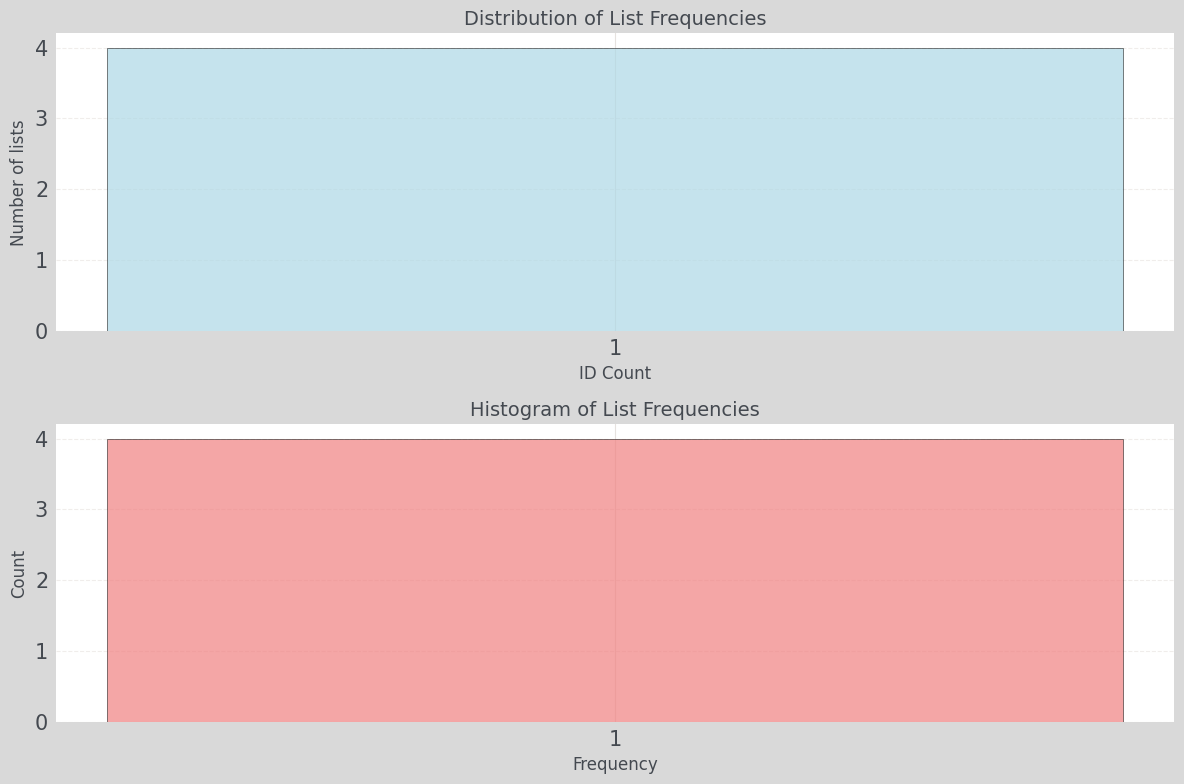

In [22]:
args = Arguments()

if args:
    set_seed(args.seed)

    print("DDP training")

    # Accelerator
    logging_dir = os.path.join(args.output_dir, args.logging_dir)
    accelerator_project_config = ProjectConfiguration(
        project_dir=args.output_dir, logging_dir=logging_dir
    )
    kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
        kwargs_handlers=[kwargs],
    )

    # Make one log on every process with the configuration for debugging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        transformers_utils_logging.set_verbosity_warning()
    else:
        transformers_utils_logging.set_verbosity_error()

    # Seed
    set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)
            print(f"Created a repo {args.output_dir}")

    # Data
    data_path = args.data_path
    train_queries_path = os.path.join(data_path, args.train_queries_filename)
    syn_queries_path = os.path.join(data_path, args.syn_queries_filename)
    dev_queries_path = os.path.join(data_path, args.dev_queries_filename)
    corpus_path = os.path.join(data_path, args.corpus_filename)

    per_device_train_batch_size = args.per_device_train_batch_size

    # Prompt templates
    corpus_prompt_template = Prompt(
        before=args.doc_prompt_before,
        after=args.doc_prompt_after,
    )
    query_prompt_template = Prompt(
        before=args.query_prompt_before,
        after=args.query_prompt_after,
    )

    # Corpus
    corpus_dataset = SciFactCorpusDataset(
        corpus_path,
    )
    corpus_dataloader = DataLoader(
        corpus_dataset,
        batch_size=per_device_train_batch_size,
        shuffle=False,
        num_workers=args.dataloader_num_workers,
    )
    corpus_dict = corpus_dataset.get_corpus_dict()

    # Queries
    real_train_dataloader = get_scifact_query_dataloader(
        queries_path=train_queries_path,
        corpus_dict=corpus_dict,
        batch_size=per_device_train_batch_size,
        shuffle=True,
        num_workers=args.dataloader_num_workers,
    )
    if args.train_on_syn_data:
        train_dataloader = get_scifact_query_dataloader(
            queries_path=[syn_queries_path, train_queries_path],
            corpus_dict=corpus_dict,
            batch_size=per_device_train_batch_size,
            shuffle=True,
            num_workers=args.dataloader_num_workers,
        )
    else:
        train_dataloader = real_train_dataloader

    dev_dataloader = get_scifact_query_dataloader(
        queries_path=dev_queries_path,
        corpus_dict=corpus_dict,
        batch_size=per_device_train_batch_size,
        shuffle=False,
        num_workers=args.dataloader_num_workers,
    )

    # Data type
    torch_dtype = getattr(torch, args.torch_dtype)

    # Model
    if "query_model" not in locals():
        print("Loading models...")
        query_model_name_or_path = TRANSFORMERS_PATH_MAP[args.query_model_alias]
        doc_model_name_or_path = TRANSFORMERS_PATH_MAP[args.doc_model_alias]
        if "query_model_copy" not in locals():
            query_model_copy, train_tokenizer = get_model_and_tokenizer(
                query_model_name_or_path,
                model_max_length=args.train_max_length,
                torch_dtype=torch_dtype,
                padding_side="right",
            )
        if "doc_model" not in locals():
            doc_model, inference_tokenizer = get_model_and_tokenizer(
                doc_model_name_or_path,
                model_max_length=args.inference_max_length,
                torch_dtype=torch_dtype,
                padding_side="left",
            )
            doc_model.to(accelerator.device, dtype=torch_dtype)

        query_model = copy.deepcopy(query_model_copy)
        query_model.to(accelerator.device, dtype=torch_dtype)

    # Only train the query model
    query_model.train()
    doc_model.eval()
    doc_model.requires_grad_(False)

    # Optimizer and learning rate scheduler
    num_warmup_steps_for_scheduler = args.lr_warmup_steps * accelerator.num_processes
    len_train_dataloader_after_sharding = math.ceil(
        len(train_dataloader) / accelerator.num_processes
    )
    num_update_steps_per_epoch = math.ceil(
        len_train_dataloader_after_sharding / args.gradient_accumulation_steps
    )
    num_training_steps_for_scheduler = (
        args.num_train_epochs * accelerator.num_processes * num_update_steps_per_epoch
    )
    params_to_optimize = [
        {
            "params": list(filter(lambda p: p.requires_grad, query_model.parameters())),
            "lr": args.learning_rate,
        },
    ]

    optimizer = AdamW(
        params_to_optimize,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )
    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # The size of the training dataloader may have changed due to accelerator.prepare, so we need to recalculate our total training steps
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    if num_training_steps_for_scheduler != max_train_steps:
        logger.warning(
            f"The length of the 'train_dataloader' after 'accelerator.prepare' ({len(train_dataloader)}) does not match "
            f"the expected length ({len_train_dataloader_after_sharding}) when the learning rate scheduler was created. "
            f"This inconsistency may result in the learning rate scheduler not functioning properly."
        )
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    genx_transformer = GenXTransformer(
        query_model=query_model,
        doc_model=doc_model,
        train_tokenizer=train_tokenizer,
        inference_tokenizer=inference_tokenizer,
        num_beams=args.num_beams,
        num_next_tokens=args.num_next_tokens,
    )
    print(genx_transformer.genx_gen_kwargs)

    # Prepare everything with our accelerator
    (
        query_model,
        doc_model,
        optimizer,
        corpus_dataloader,
        train_dataloader,
        dev_dataloader,
        lr_scheduler,
    ) = accelerator.prepare(
        query_model,
        doc_model,
        optimizer,
        corpus_dataloader,
        train_dataloader,
        dev_dataloader,
        lr_scheduler,
    )

    # Report
    if accelerator.is_main_process and args.do_report:
        tracker_name = args.tracker_name
        accelerator.init_trackers(tracker_name, config=vars(args))

    store = SequencePrefixTreeIndexStore(
        genx_transformer,
        id_len=args.num_next_tokens,
        universe=set(range(genx_transformer.inference_tokenizer.vocab_size)),
        doc_prompt=corpus_prompt_template,
        query_prompt=query_prompt_template,
        mode="document_search",
        insertion_depth=args.insertion_depth,
    )
    store.clear_store()
    store.set_verbose_for_all(False)

    store_state_path = os.path.join(args.output_dir, args.store_state_filename)
    if args.load_store_state and os.path.exists(store_state_path):
        logger.info("Loading state...")
        store.load_state(store_state_path)
        if len(store._beams_store) < 10:
            store.print_beams_store()
            print()
        store.plot_list_frequencies(
            store._beams_store,
            figsize=(12, 8),
            save_path=os.path.join(args.output_dir, "freq.pdf"),
            verbose=True if accelerator.is_main_process else False,
        )
    else:
        logger.info("Inserting corpus into data store...")
        for batch in corpus_dataloader:
            doc_ids = batch["doc_id"]
            texts = batch["text"]
            to_be_inserted = []
            for doc_id, text in zip(doc_ids, texts):
                doc_id = doc_id.cpu().item()
                to_be_inserted.append(Document(text, {"doc_id": doc_id}))
            store.insert(to_be_inserted)
        if len(store._beams_store) < 10:
            store.print_beams_store()
            print()
        store.save_state(store_state_path)
        store.plot_list_frequencies(
            store._beams_store,
            figsize=(12, 8),
            save_path=os.path.join(args.output_dir, "freq.pdf"),
            verbose=True if accelerator.is_main_process else False,
        )

    # Log some info about our training
    total_batch_size = (
        per_device_train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    max_train_steps = num_train_epochs * num_update_steps_per_epoch
    logger.info("***** Running training *****")
    logger.info(f"Num examples = {len(train_dataloader.dataset)}")
    logger.info(f"Num batches each epoch = {len(train_dataloader)}")
    logger.info(f"Num epochs = {num_train_epochs}")
    logger.info(f"Instantaneous batch size per device = {per_device_train_batch_size}")
    logger.info(
        f"Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}"
    )
    logger.info(f"Gradient accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"Number of update steps per epoch = {num_update_steps_per_epoch}")
    logger.info(f"Total optimization steps = {max_train_steps}")
    logger.info(f"Checkpointing epochs = {args.checkpointing_epochs}")
    logger.info(f"Validation epochs = {args.validation_epochs}")
    checkpointing_steps = args.checkpointing_epochs * num_update_steps_per_epoch
    global_step = 0
    first_epoch = 0

    best_dev_f1 = 0.0
    best_train_metrics = {}
    best_dev_metrics = {}

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the mos recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch
    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )
    epoch = first_epoch
    for epoch in range(first_epoch, num_train_epochs):
        query_model.train()
        for _, batch in enumerate(train_dataloader):
            models_to_accumulate = [query_model]
            with accelerator.accumulate(models_to_accumulate):
                doc_ids = batch["doc_id"]
                queries = batch["query"]
                docs = batch["text"]
                docs = [corpus_prompt_template.format(text) for text in docs]
                queries = [query_prompt_template.format(query) for query in queries]

                beams_for_docs = []
                all_processed = True
                for doc_id in doc_ids:
                    if doc_id not in store._original_keys.values():
                        all_processed = False
                        break
                if all_processed:
                    for doc_id in doc_ids:
                        id = store._original_keys_transpose[doc_id]
                        beams_for_docs.append(store._beams_store[id])
                    loss = genx_transformer(queries, beams_for_docs)
                else:
                    loss = genx_transformer(queries, docs)

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = itertools.chain(query_model.parameters())
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process:
                    if global_step % checkpointing_steps == 0:
                        save_path = os.path.join(
                            args.output_dir, f"checkpoint-{global_step}"
                        )
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= max_train_steps:
                break

        # Validate!
        if accelerator.is_main_process:
            if epoch % args.validation_epochs == 0:
                train_metrics = log_validation(
                    store,
                    real_train_dataloader,
                    accelerator,
                    epoch,
                    split="train",
                    global_step=global_step,
                    is_final_validation=False,
                )
                dev_metrics = log_validation(
                    store,
                    dev_dataloader,
                    accelerator,
                    epoch,
                    split="dev",
                    global_step=global_step,
                    is_final_validation=False,
                )
                dev_f1 = dev_metrics["f1"]
                if dev_f1 > best_dev_f1:
                    best_dev_f1 = dev_f1
                    best_dev_metrics = dev_metrics
                    best_train_metrics = train_metrics

    # Evaluate!
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        train_metrics = log_validation(
            store,
            real_train_dataloader,
            accelerator,
            epoch,
            split="train",
            global_step=global_step,
            is_final_validation=True,
        )
        dev_metrics = log_validation(
            store,
            dev_dataloader,
            accelerator,
            epoch,
            split="dev",
            global_step=global_step,
            is_final_validation=True,
        )
        dev_f1 = dev_metrics["f1"]
        if dev_f1 > best_dev_f1:
            best_dev_f1 = dev_f1
            best_dev_metrics = dev_metrics
            best_train_metrics = train_metrics

    # Finish
    accelerator.end_training()
    best_metrics = {
        "train": best_train_metrics,
        "dev": best_dev_metrics,
    }
    with open(os.path.join(args.output_dir, "metrics.json"), "w") as f:
        json.dump(best_metrics, f, indent=4)


In [23]:
store.set_verbose_for_all(True)
train_metrics = log_validation(
    store,
    real_train_dataloader,
    accelerator,
    epoch,
    split="train",
    global_step=global_step,
    is_final_validation=True,
)
print(train_metrics)
store.set_verbose_for_all(False)

Querying for '[<__main__.Document object at 0x7f3156284e00>, <__main__.Document object at 0x7f315626a1e0>, <__main__.Document object at 0x7f3156268230>, <__main__.Document object at 0x7f3156268830>]'
1-1% of colorectal cancer patients are diagnosed with regional or distant metastases.Give me potential keywords of related articles.
1 in 5 million in UK have abnormal PrP positivity.Give me potential keywords of related articles.
10% of sudden infant death syndrome (SIDS) deaths happen in newborns aged less than 6 months.Give me potential keywords of related articles.
0-dimensional biomaterials lack inductive properties.Give me potential keywords of related articles.
Decoded tokens: [' RNA, the', ' myelod', 'ethylome of', ' of human newborn']
Token IDs: [[[41214, 11, 279]], [[856, 301, 347]], [[42972, 638, 315]], [[315, 3823, 46397]]]
Tokens: [41214, 11, 279]
Found results:  [{'depth': 3, 'doc_ids': {2}, 'index_ids': [41214, 11, 279], 'index_txt': [' RNA', ',', ' the']}]
Tokens: [856, 301

In [25]:
len(store._beams_store)

4